In [1]:
# navigate to where the pre-trained model is located 
%cd Pointnet_Pointnet2_pytorch

C:\Users\Manali Badwe\Documents\Masters Fall\Research\Pointnet_Pointnet2_pytorch


In [2]:
import sys
import os
import importlib.util
import torch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import open3d as o3d
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), 'models'))

from pointnet_cls import get_model

# Initialize the model architecture where k = number of classes 
model = get_model(k=40)  

# Load the pre-trained weights
print(os.getcwd())
model.load_state_dict(torch.load('log/classification/pointnet2_ssg_wo_normals/checkpoints/best_model.pth', map_location=torch.device('cpu')), strict=False)

# Set the model to evaluation mode
model.eval()

# setting the class name labels 
class_names = [
    'airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car',
    'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot',
    'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor',
    'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
    'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase',
    'wardrobe', 'xbox']

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
C:\Users\Manali Badwe\Documents\Masters Fall\Research\Pointnet_Pointnet2_pytorch


C:\Users\Manali Badwe\AppData\Local\Temp\ipykernel_22360\1160302568.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('log/classification

In [3]:
# kmeans clustering algorithm to separate point cloud into a certain number of clusters 
def kmeans(points, num_clusters, init_clusters):
    points = np.asarray(points)
    kmeans = KMeans(n_clusters=num_clusters, init=init_clusters).fit(points)
    labels = kmeans.labels_

    clusters = [points[labels == i] for i in range(num_clusters)]
    return clusters, kmeans.cluster_centers_

def classify(cluster_points, model, class_names):
    # Shape (1, num_points, 3) 
    cluster_tensor = torch.tensor(cluster_points, dtype=torch.float32, requires_grad=True)
    normals = compute_normals(cluster_points) 

    # Shape (1, num_points, 6) 
    cluster_tensor_with_normals = torch.cat([cluster_tensor, torch.tensor(normals, dtype=torch.float32)], dim=1).unsqueeze(0).permute(0, 2, 1)

    with torch.no_grad(): 
        output = model(cluster_tensor_with_normals) 

        # Unpack output if it is a tuple 
        
        if isinstance(output, tuple):
                output = output[0]
                

        # Get the predicted class index 
        probabilities = F.softmax(output, dim=1) 
        predicted_class_idx = torch.argmax(probabilities, dim=1).item() 
        confidence_score = probabilities[0, predicted_class_idx].item() 
        all_probabilities = probabilities.squeeze(0).numpy() 
        prediction = class_names[predicted_class_idx]
    
    return prediction, confidence_score, all_probabilities, predicted_class_idx  

# Visualize clusters with each cluster identified with a unique color 
def visualize(clusters):
    # Define a set pattern of colors (e.g., red, blue, green, yellow, etc.)
    predefined_colors = [
        [1, 0, 0],  # Red
        [0, 0, 1],  # Blue
        [0, 1, 0],  # Green
        [1, 1, 0],  # Yellow
    ]
    
    o3d_clusters = []
    for i, cluster in enumerate(clusters):
        if len(cluster) == 0:
            continue
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(cluster)
        
        # Assign a color from the predefined list
        color = predefined_colors[i % len(predefined_colors)]
        pcd.paint_uniform_color(color)
        o3d_clusters.append(pcd)
    
    # Visualize the point clouds
    o3d.visualization.draw_geometries(o3d_clusters)



In [4]:
# Plot all of the probabilities for all the class names as a histogram 
def plot_class_histogram(all_probabilities, class_names, title):
    num_clusters = len(all_probabilities)
    cols = 2  # Number of columns for subplots
    rows = (num_clusters + 1) // cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(14, 4 * rows))
    fig.suptitle(f'Class Probabilities for Each Cluster for {title}', fontsize=16)

    for i, probabilities in enumerate(all_probabilities):
        row = i // cols
        col = i % cols
        ax = axs[row, col] if rows > 1 else axs[col]  # Handle case for single row
        
        ax.bar(class_names, probabilities)
        ax.set_title(f'Cluster {i+1}')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Probability')
        ax.set_xticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=90)
    
    # Hide any empty subplots if the number of clusters is not even
    for j in range(i + 1, rows * cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for title
    plt.show()

In [5]:
def plot_loss(loss_history, title): 
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(loss_history)), loss_history, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Function to compute normals using K-NN and PCA
def compute_normals(points, k_neighbors=10):
    points = np.asarray(points)

    # Find K nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(points)
    distances, indices = nbrs.kneighbors(points)

    normals = []
    for i in range(len(points)):
        neighbors = points[indices[i]]
        '''
        if np.linalg.norm(neighbors - neighbors.mean(axis=0)) < 1e-6:
            # Use mean normal as a fallback
            mean_normal = np.mean(neighbors - np.mean(neighbors, axis=0), axis=0)
            mean_normal /= np.linalg.norm(mean_normal)  # Normalize the fallback normal
            normals.append(mean_normal)
            continue

'''
        pca = PCA(n_components=3)
        pca.fit(neighbors)

        # The normal is the eigenvector corresponding to the smallest eigenvalue
        normal = pca.components_[-1]  # Last component corresponds to the smallest eigenvalue

        # Ensure normal points outward
        if np.dot(normal, points[i] - np.mean(neighbors, axis=0)) < 0:
            normal = -normal

        normals.append(normal)

    return np.array(normals)

def outlier_removal(points, nb_neighbors=60, std_ratio=2): 
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    
    cl, ind = point_cloud.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    
    # Separate inliers and outliers
    inlier_cloud = point_cloud.select_by_index(ind)
    inlier_points = np.asarray(inlier_cloud.points) 
    
    return inlier_points

In [7]:
def plot_class_histogram_multiple(probabilities_pre, probabilities_post, class_names, title):
    num_clusters = len(all_probabilities)
    cols = 2  # Number of columns for subplots
    rows = (num_clusters + 1) // cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(14, 4 * rows))
    fig.suptitle(f'Class Probabilities for Each Cluster for {title}', fontsize=16)
    x = np.arange(len(class_names))
    width = 0.35
    
    for i, (pre, post) in enumerate(zip(probabilities_pre, probabilities_post)):
        row = i // cols
        col = i % cols
        ax = axs[row, col] if rows > 1 else axs[col]  # Handle case for single row
        
        
        ax.bar(x - width / 2, pre, width, label='Pre-Cleanup', color='blue', alpha=0.7)
        # Plot post-cleanup probabilities
        ax.bar(x + width / 2, post, width, label='Post-Cleanup', color='orange', alpha=0.7)
        ax.set_title(f'Cluster {i+1}')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Probability')
        ax.set_xticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=90)
        ax.legend()
    
    # Hide any empty subplots if the number of clusters is not even
    for j in range(i + 1, rows * cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for title
    plt.show()

In [8]:
def compute_classification_loss(output, target_class_idx): 
    all_probabilities = torch.softmax(output, dim=1).squeeze() 
    
    target_score = all_probabilities[target_class_idx]
    classification_loss = -torch.log(target_score + 1e-8) 

    return classification_loss, target_score

In [9]:
def compute_movement_loss(points_tensor, original_points_tensor): 
    movement_loss = torch.norm(points_tensor - original_points_tensor, p=2) 
    return movement_loss 

In [10]:

def compute_pullback_loss(points_tensor, normals, cluster_center, outlier_threshold, neighbor_weight, normal_weight): 
    pairwise_distances = torch.cdist(points_tensor, points_tensor, p=2) 
    knn_indices = pairwise_distances.topk(k=16, largest=False).indices[:, 1:]

    pullback_loss = torch.tensor(0.0, dtype=torch.float32)

    centroid = torch.tensor(cluster_center, dtype=torch.float32)
    distances = torch.norm(points_tensor - centroid, dim=1)
    outlier_mask = distances > outlier_threshold
    
    for idx, point in enumerate(points_tensor): 
            neighbors = points_tensor[knn_indices[idx]]
            neighbor_normals = torch.tensor(normals, dtype=torch.float32)[knn_indices[idx]]
                    
            similarity_loss = torch.mean(torch.norm(point - neighbors, dim=1))
        
            neighbor_centroid = torch.mean(neighbors, dim=0)
            normal_vector = torch.tensor(normals[idx], dtype=torch.float32)
            normal_pullback = torch.dot(point - neighbor_centroid, normal_vector)

           
            
             # Stronger pullback for outliers
            if outlier_mask[idx]:
                outlier_penalty = 50.0 * neighbor_weight * similarity_loss + normal_weight * normal_pullback  # Higher penalty for outliers
            
            else:
                outlier_penalty = 0.0

    pullback_loss = pullback_loss + outlier_penalty
    return pullback_loss 


'''
def compute_pullback_loss(points, normals, cluster_center, outlier_threshold, neigbhor_weight, normal_weight):
    outlier_weight = 10 
    density_weight = 10 
  
    centroid = torch.tensor(cluster_center, dtype=torch.float32)
    distances = torch.norm(points - centroid, dim=1)
    outlier_mask = distances > outlier_threshold  


    outlier_loss = torch.sum(outlier_mask * distances.pow(2))

    pairwise_distances = torch.cdist(points, points, p=2)
    local_densities = torch.mean(pairwise_distances, dim=1)
    density_loss = torch.sum((local_densities - local_densities.mean()).pow(2))

    total_loss = outlier_weight * outlier_loss + density_weight * density_loss

    return total_loss

'''

'''
def compute_pullback_loss(points_tensor, normals, cluster_center, outlier_threshold, neighbor_weight, normal_weight):

    """
    Compute pullback loss to handle outliers and maintain a dense point cloud.

    Args:
        points (torch.Tensor): Tensor of shape (N, 3) representing the points.
        normals (torch.Tensor): Tensor of shape (N, 3) representing the normals.
        knn_indices (torch.Tensor): Indices of the k-nearest neighbors for each point.
        cluster_center (torch.Tensor): Tensor of shape (3,) for the cluster center.
        outlier_threshold (float): Distance beyond which points are considered outliers.
        neighbor_weight (float): Weight for the neighbor similarity term.
        normal_weight (float): Weight for the normal alignment term.

    Returns:
        torch.Tensor: Scalar loss value.
    """

    pairwise_distances = torch.cdist(points_tensor, points_tensor, p=2) 
    knn_indices = pairwise_distances.topk(k=16, largest=False).indices[:, 1:]
    
    pullback_loss = 0.0
    centroid = torch.tensor(cluster_center, dtype=torch.float32)
    distances = torch.norm(points_tensor - centroid, dim=1)
    outlier_mask = distances > outlier_threshold

    for idx, point in enumerate(points_tensor):
        # Get neighbors for the current point
        neighbors = points_tensor[knn_indices[idx]]
        neighbor_normals = normals[knn_indices[idx]]

        # Similarity loss: Pull points closer to their neighbors
        similarity_loss = torch.mean(torch.norm(point - neighbors, dim=1))
        
        # Normal alignment loss: Align normals with neighbors
        normal_vector = normals[idx]
        neighbor_centroid = torch.mean(neighbors, dim=0)
        normal_pullback = torch.dot(point - neighbor_centroid, normal_vector)

        # Stronger pullback for outliers
        if outlier_mask[idx]:
            outlier_penalty = 2.0 * torch.norm(point - centroid)  # Higher penalty for outliers
        else:
            outlier_penalty = 0.0

        # Weighted combination of terms
        pullback_loss += (
            neighbor_weight * similarity_loss
            + normal_weight * normal_pullback
            + outlier_penalty
        )

    return pullback_loss
'''


'\ndef compute_pullback_loss(points_tensor, normals, cluster_center, outlier_threshold, neighbor_weight, normal_weight):\n\n    """\n    Compute pullback loss to handle outliers and maintain a dense point cloud.\n\n    Args:\n        points (torch.Tensor): Tensor of shape (N, 3) representing the points.\n        normals (torch.Tensor): Tensor of shape (N, 3) representing the normals.\n        knn_indices (torch.Tensor): Indices of the k-nearest neighbors for each point.\n        cluster_center (torch.Tensor): Tensor of shape (3,) for the cluster center.\n        outlier_threshold (float): Distance beyond which points are considered outliers.\n        neighbor_weight (float): Weight for the neighbor similarity term.\n        normal_weight (float): Weight for the normal alignment term.\n\n    Returns:\n        torch.Tensor: Scalar loss value.\n    """\n\n    pairwise_distances = torch.cdist(points_tensor, points_tensor, p=2) \n    knn_indices = pairwise_distances.topk(k=16, largest=False

In [11]:
def compute_repulsion_loss(points_tensor, min_dist=0.1):
    distances = torch.cdist(points_tensor, points_tensor, p=2)
    mask = (distances > 0) & (distances < min_dist)
    loss = torch.sum((min_dist - distances[mask])**2)
    return loss

In [12]:
def visualize_normals(points, normals, scale=5):
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Create lines to represent normals
    line_set = o3d.geometry.LineSet()
    start_points = points
    end_points = points + normals * scale
    lines = [[i, i + len(points)] for i in range(len(points))]
    
    # Combine points and lines
    combined_points = np.vstack((start_points, end_points))
    line_set.points = o3d.utility.Vector3dVector(combined_points)
    line_set.lines = o3d.utility.Vector2iVector(lines)

    # Visualize
    pcd.colors = o3d.utility.Vector3dVector(np.tile([1.0, 0, 0], (points.shape[0], 1)))
    o3d.visualization.draw_geometries([pcd, line_set])

In [13]:
# Function to visualize normals and assign planes
def visualize_planes_from_normals(pcd, normals, angle_threshold_deg=45):
    num_points = len(normals)
    
    # Normalize normals
    normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
    
    # Threshold for plane similarity (in radians)
    angle_threshold = np.deg2rad(angle_threshold_deg)
    
    # Initialize plane assignments
    plane_ids = np.full(num_points, -1)  # -1 means unassigned
    plane_count = 0
    
    # Assign planes based on normal similarity
    for i in range(num_points):
        if plane_ids[i] == -1:  # Only process unassigned points
            plane_ids[i] = plane_count
            # Compute angular difference with all other normals
            dot_products = np.dot(normals, normals[i])
            angles = np.arccos(np.clip(dot_products, -1.0, 1.0))
            similar_points = angles < angle_threshold
            plane_ids[similar_points] = plane_count
            plane_count += 1
    
    # Assign colors to each plane
    unique_planes = np.unique(plane_ids)
    colors = np.zeros((num_points, 3))  # Default black color
    color_map = plt.colormaps["tab20"]  # Use updated colormap method
          # Generate a color map
    
    for plane_id in unique_planes:
        if plane_id != -1:  # Skip unassigned points
            colors[plane_ids == plane_id] = color_map(int(plane_id))[:3]

    # Apply colors to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Visualize point cloud with normals and colored planes
    o3d.visualization.draw_geometries([pcd])
    return plane_count  # Return the number of planes found


In [44]:
def find_point_knn(points_tensor, query_point, k=10): 
    if query_point.dim() == 1:
        query_point = query_point.unsqueeze(0) 

    k = min(k, points_tensor.shape[0])
    # Calculate distances from query point to all points
    distances = torch.cdist(query_point, points_tensor)
    # Get k nearest neighbors
    _, indices = torch.topk(distances, k=k, dim=1, largest=False)
    
    return indices.squeeze(0) 

In [45]:
def ransac_plane_segmentation(points_tensor, distance_threshold, ransac_n, num_iterations): 
    num_points = points_tensor.shape[0] 
    best_inlier_count = 0 
    best_inliers = None 
    best_plane_model = None 

    for i in range(num_iterations): 
        sampled_indices = torch.randperm(num_points)[:ransac_n]
        sampled_points = points_tensor[sampled_indices] 
        
        subset_indices = torch.randperm(ransac_n)[:3]

        p1 = sampled_points[subset_indices[0]]
        
        k_nn = find_point_knn(points_tensor, p1) 
        neighbors = points_tensor[k_nn]      
                
        p2 = neighbors[subset_indices[1]]
        p3 = neighbors[subset_indices[2]]
        
        normal = torch.cross(p2-p1, p3-p1) 

        if torch.norm(normal) < 1e-6: 
            continue 

        normal = normal/torch.norm(normal) 
        d = -torch.dot(normal, p1)
        plane_model = torch.cat((normal, d.view(-1)))

        distances = torch.abs(torch.mm(points_tensor, normal.view(3, 1)).squeeze() + d)
        distances = distances/torch.norm(normal)

        inliers = torch.where(distances < distance_threshold)[0]
        inlier_count = len(inliers)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_plane_model = plane_model
            best_inliers = inliers

    return best_plane_model, best_inliers

In [57]:
def multi_plane_segmentation(points_tensor, distance_threshold=1, ransac_n=3, num_iterations=3000, min_inlier_ratio=0.01):
    remaining_indices = torch.arange(len(points_tensor))
    total_points = len(points_tensor)
    planes = []
    all_inliers = []
    all_outliers = []
    
    while True:
        plane_model, inlier_indices = ransac_plane_segmentation(
            points_tensor[remaining_indices], distance_threshold, ransac_n, num_iterations
        )
        
        if inlier_indices is None or len(inlier_indices) / total_points < min_inlier_ratio:
            break
            
        # Map inlier indices back to original point indices
        original_inliers = remaining_indices[inlier_indices]
        
        planes.append(plane_model)
        all_inliers.append(original_inliers)
        
        # Create mask for remaining points
        mask = torch.ones(len(remaining_indices), dtype=torch.bool)
        mask[inlier_indices] = False
        
        # Store outlier indices
        outlier_indices = remaining_indices[mask]
        all_outliers.append(outlier_indices)
        
        # Update remaining indices
        remaining_indices = remaining_indices[mask]
        
        if len(remaining_indices) < ransac_n:
            break
        
    return planes, all_inliers, all_outliers

In [47]:
def visualize_detected_planes(points_tensor, all_inliers):
    # Convert points_tensor to numpy for Open3D compatibility
    points_np = points_tensor.detach().numpy()

    # Initialize colors for each point
    num_points = points_np.shape[0]
    colors = np.zeros((num_points, 3))  # Default color: black

    # Assign a random color to each plane
    for plane_id, inliers in enumerate(all_inliers):
        # Generate a random RGB color
        plane_color = np.random.rand(3)  # Random values between 0 and 1
        colors[inliers] = plane_color  # Assign random color to inliers of this plane

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_np)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Visualize
    o3d.visualization.draw_geometries([pcd])


In [48]:
def project_points_onto_plane(points_tensor, plane_model):
    a, b, c, d = plane_model
    # Compute distance for each point in the tensor
    distance = (a * points_tensor[:, 0] + b * points_tensor[:, 1] + c * points_tensor[:, 2] + d) / (a**2 + b**2 + c**2)
    
    # Project the points onto the plane
    x_proj = points_tensor[:, 0] - a * distance
    y_proj = points_tensor[:, 1] - b * distance
    z_proj = points_tensor[:, 2] - c * distance
    
    # Return the projected points
    projected_points = torch.stack([x_proj, y_proj, z_proj], dim=1)
    return projected_points


In [49]:
def project_outliers_onto_closest_plane(points_tensor, planes, outliers):
    # Convert outliers to a tensor if it's a list
    if isinstance(outliers, list):
        outliers = torch.tensor(outliers, dtype=torch.long)
    else:
        outliers = outliers.long()

    # Initialize an empty list for the projected points
    projected_outliers = []
    for outlier_idx in outliers:
        outlier = points_tensor[outlier_idx] 
        min_distance = float('inf')
        closest_plane = None

        # Iterate through all detected planes
        for plane_model in planes:
            a, b, c, d = plane_model
            # Compute the distance from the outlier to the current plane
            distance = abs(a * outlier[0] + b * outlier[1] + c * outlier[2] + d) / (a**2 + b**2 + c**2)**0.5
            # Update the closest plane if this one is closer
            if distance < min_distance:
                min_distance = distance
                closest_plane = plane_model

        # Project the outlier onto the closest plane
        if closest_plane is not None:
            a, b, c, d = closest_plane
            distance = (a * outlier[0] + b * outlier[1] + c * outlier[2] + d) / (a**2 + b**2 + c**2)
            x_proj = outlier[0] - a * distance
            y_proj = outlier[1] - b * distance
            z_proj = outlier[2] - c * distance
            projected_outliers.append([x_proj, y_proj, z_proj])

    # Convert the projected points back to a tensor
    return torch.tensor(projected_outliers, dtype=torch.float32)



In [50]:
def multi_plane_segmentation_and_project(points_tensor, distance_threshold, ransac_n, num_iterations, min_inlier_ratio):
    # Step 1: Perform multi-plane segmentation excluding inliers
    planes, outliers = multi_plane_segmentation(points_tensorions, min_inlier_ratio)
    
    # Step 2: Project the outliers onto the closest plane
    projected_outliers = project_outliers_onto_closest_plane(points_tensor, planes, outliers)
    
    return projected_outliers

In [51]:
def find_closest_plane_distance(point, planes):
    # point: tensor([x, y, z])
    # planes: list of tensors where each plane is [nx, ny, nz, d]
    min_distance = float('inf')
    
    for plane in planes:
        normal = plane[:3]  # First 3 components are normal
        d = plane[3]       # Last component is d
        distance = abs(torch.dot(point, normal) + d) / torch.norm(normal)
        min_distance = min(min_distance, distance)
    
    return min_distance

In [59]:
def find_outliers_tensor(points_tensor, radius=2, min_neighbors=20):
    points = points_tensor.detach().numpy()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    tree = o3d.geometry.KDTreeFlann(pcd)
    checked = set()
    outlier_indices = []
    
    for i in range(len(points_tensor)):
        if i in checked:
            continue
        [k, idx, _] = tree.search_radius_vector_3d(pcd.points[i], radius)
        if k < min_neighbors:
            group = set(np.asarray(idx))
            if not any(i in checked for i in group):
                outlier_indices.extend(list(group))
            checked.update(group)
        checked.add(i)
    
    return outlier_indices

def optimize_cluster(points, model, target_class_idx, cluster_center, num_epochs=200, lr=0.05):
    lambda_reg=1
    pullback_strength=20
    classification_weight = 5
    normal_weight = 5
    neighbor_weight = 5
    repulsion_weight = 0
    

    #Thresholds 
    outlier_threshold=0.01
    neighbor_threshold=0.001

    # Convert points to a tensor and enable gradients
    points_tensor = torch.tensor(points, dtype=torch.float32, requires_grad=True)
   
    original_points_tensor = torch.tensor(points, dtype=torch.float32, requires_grad=False)

    # Set model to evaluation mode (doesn't update model weights)
    model.eval()
    normals = compute_normals(points)

    # Optimizer for points and keep track of loss value 
    optimizer = torch.optim.Adam([points_tensor], lr=lr)
    loss_history = [] 
    classification_history = [] 
    movement_history = [] 
    pullback_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
    
        # Prepare the input for the model (expand dimensions and add dummy normals)
        input_tensor = torch.cat([points_tensor, torch.tensor(normals, dtype=torch.float32)], dim=1).unsqueeze(0).permute(0, 2, 1)

        # Forward pass through the model
        output = model(input_tensor)
        
        if isinstance(output, tuple):
            output = output[0]
    
        classification_loss, target_score = compute_classification_loss(output, target_class_idx)
        movement_loss = compute_movement_loss(points_tensor, original_points_tensor) 
        #pullback_loss = compute_pullback_loss(points_tensor, normals, cluster_center, outlier_threshold, neighbor_weight, normal_weight)
        pullback_loss = torch.tensor(0.0, dtype=torch.float32)
        

        outlier_indices = find_outliers_tensor(points_tensor) 
        if len(outlier_indices) > 0:
            outlier_points = points_tensor[outlier_indices]
            non_outlier_points = points_tensor[list(set(range(len(points_tensor))) - set(outlier_indices))]
            planes, _,_ = multi_plane_segmentation(non_outlier_points) 
            
            # Stronger pullback force
            for idx, outlier in enumerate(outlier_points):
                '''
                distances = torch.norm(non_outlier_points - outlier.unsqueeze(0), dim=1)
                closest_idx = torch.argmin(distances)
                closest_point = non_outlier_points[closest_idx]
        
                # Direct movement towards closest point
                direction = closest_point - outlier
                '''
                distance = find_closest_plane_distance(outlier, planes) 
                #pullback_loss += torch.norm(direction) * 100  # Increased weight
                pullback_loss += distance  

        '''                                                 
        planes, all_inliers, all_outliers = multi_plane_segmentation(points_tensor)
        outliers = torch.cat(all_outliers)
        projected_outliers = project_outliers_onto_closest_plane(points_tensor, planes, outliers)

        mask = torch.ones(len(points_tensor), dtype=torch.bool)
        mask[outliers] = False

        updated_points_tensor = points_tensor.clone()
        updated_points_tensor[outliers] = projected_outliers
        points_tensor.data = updated_points_tensor.data
        '''
       # repulsion_loss = compute_repulsion_loss(points_tensor) 

        # Total loss 
        loss = classification_weight*classification_loss + lambda_reg * movement_loss + pullback_strength * pullback_loss 
        
        # Backpropagation
        loss.backward(retain_graph=True)
        optimizer.step()
        
        loss_history.append(loss.item())
        classification_history.append(classification_loss.item()) 
        movement_history.append(movement_loss.item()) 
        pullback_history.append(pullback_loss.item())
                                                  
         # Print progress
        if epoch % 20 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, Target Score: {target_score.item()}")
            print(f"Number of points = {points_tensor.shape[0]}")
    
     

    
    # Return the optimized points as a numpy array
    return points_tensor.detach().numpy(), loss_history, classification_history, movement_history, pullback_history 
    


In [60]:
def find_outliers(points, radius=2, min_neighbors=20):

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    tree = o3d.geometry.KDTreeFlann(pcd)
    checked = set()
    outlier_groups = []
    
    for i in range(len(points)):
        if i in checked:
            continue
            
        [k, idx, _] = tree.search_radius_vector_3d(pcd.points[i], radius)
        if k < min_neighbors:
            group = set(np.asarray(idx))
            if not any(i in checked for i in group):
                outlier_groups.append(list(group))
            checked.update(group)
        checked.add(i)
    
    outliers = np.zeros(len(points), dtype=bool)
    for group in outlier_groups:
        outliers[group] = True
    
    colors = np.zeros((len(points), 3))
    colors[~outliers] = [0, 0, 1]
    colors[outliers] = [1, 0, 0]

    
   # pcd.colors = o3d.utility.Vector3dVector(colors)
   # o3d.visualization.draw_geometries([pcd])
    
    return outliers

In [61]:
mesh_pre = o3d.io.read_triangle_mesh("MFCRaw1.stl")

mesh_pre.compute_vertex_normals()
pcd_pre = mesh_pre.sample_points_uniformly(number_of_points=10000)

points_pre = np.asarray(pcd_pre.points)

points_tensor = torch.tensor(points_pre, dtype=torch.float32, requires_grad=True)

distance_threshold = 8
ransac_n = 3
num_iterations = 3000 
min_inlier_ratio = 0.2

planes, all_inliers, outliers = multi_plane_segmentation(points_tensor) 
visualize_detected_planes(points_tensor, all_inliers)

'''
planes, all_inliers = multi_plane_segmentation(points_tensor, distance_threshold, ransac_n, num_iterations, min_inlier_ratio)
visualize_detected_planes(points_tensor, all_inliers) 
#normals = compute_normals(points_pre) 
#visualize_planes_from_normals(pcd_pre, normals) 
'''

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


'\nplanes, all_inliers = multi_plane_segmentation(points_tensor, distance_threshold, ransac_n, num_iterations, min_inlier_ratio)\nvisualize_detected_planes(points_tensor, all_inliers) \n#normals = compute_normals(points_pre) \n#visualize_planes_from_normals(pcd_pre, normals) \n'

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '9'

num_clusters = 4 

init_centers = np.array([[-2.01447021e+00, 4.12421391e+01, 7.45528138e-03], 
 [-2.02275168e+00, 9.53249006e+01, -1.37869438e-01],
 [-1.94144009e+00, 1.13581038e+01, -2.58324753e-01],
 [-2.20651082e+00, 6.91070858e+01, -1.52799531e-01]])

clusters_pre, cluster_centers_pre = kmeans(points_pre, num_clusters, init_centers)
probabilities_pre = []
for cluster_pre in clusters_pre: 
    _, _, cluster_prob, _ = classify(cluster_pre, model, class_names)
    probabilities_pre.append(cluster_prob) 
 
#points_pre = outlier_removal(points_pre)
#visualize(clusters_pre)

optimized_points = []


for cluster, cluster_center in zip(clusters_pre, cluster_centers_pre):
    
    
    #cluster = outlier_removal(cluster) 
    _, _, _, target_class_idx = classify(cluster, model, class_names)
    #target_class_idx = 16 
    optimized_cluster_points, loss_history, classification, move, pull = optimize_cluster(cluster, model, target_class_idx, cluster_center)
    optimized_points.append(optimized_cluster_points)
    plot_loss(loss_history, "Total Loss") 
    plot_loss(classification, "Classification Loss") 
    plot_loss(move, "Movement Loss") 
    plot_loss(pull, "Pullback Loss") 
    


Epoch 0/200, Loss: 1145.4727783203125, Target Score: 0.050188884139060974
Number of points = 2568
Epoch 20/200, Loss: 1158.44384765625, Target Score: 0.05045721307396889
Number of points = 2568
Epoch 40/200, Loss: 2019.0350341796875, Target Score: 0.050644077360630035
Number of points = 2568


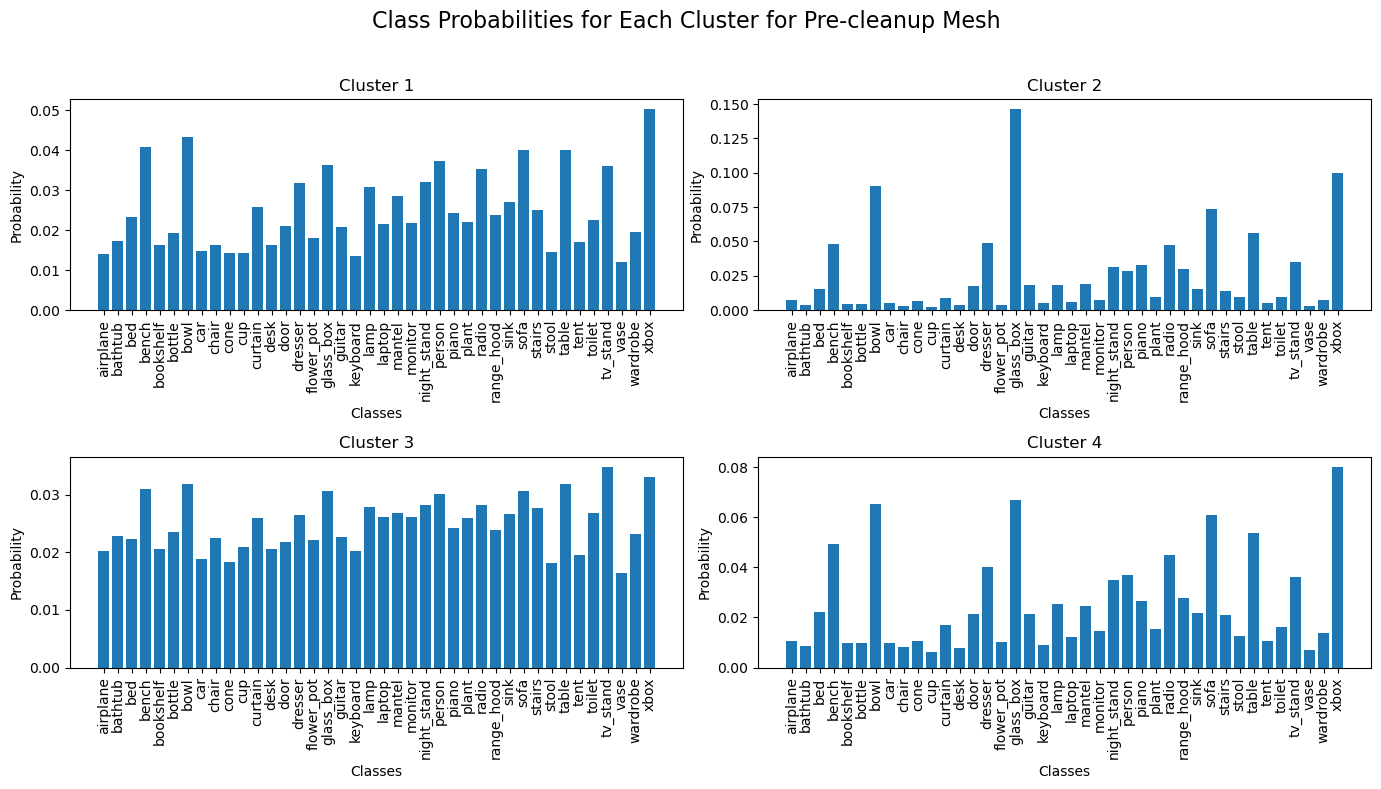

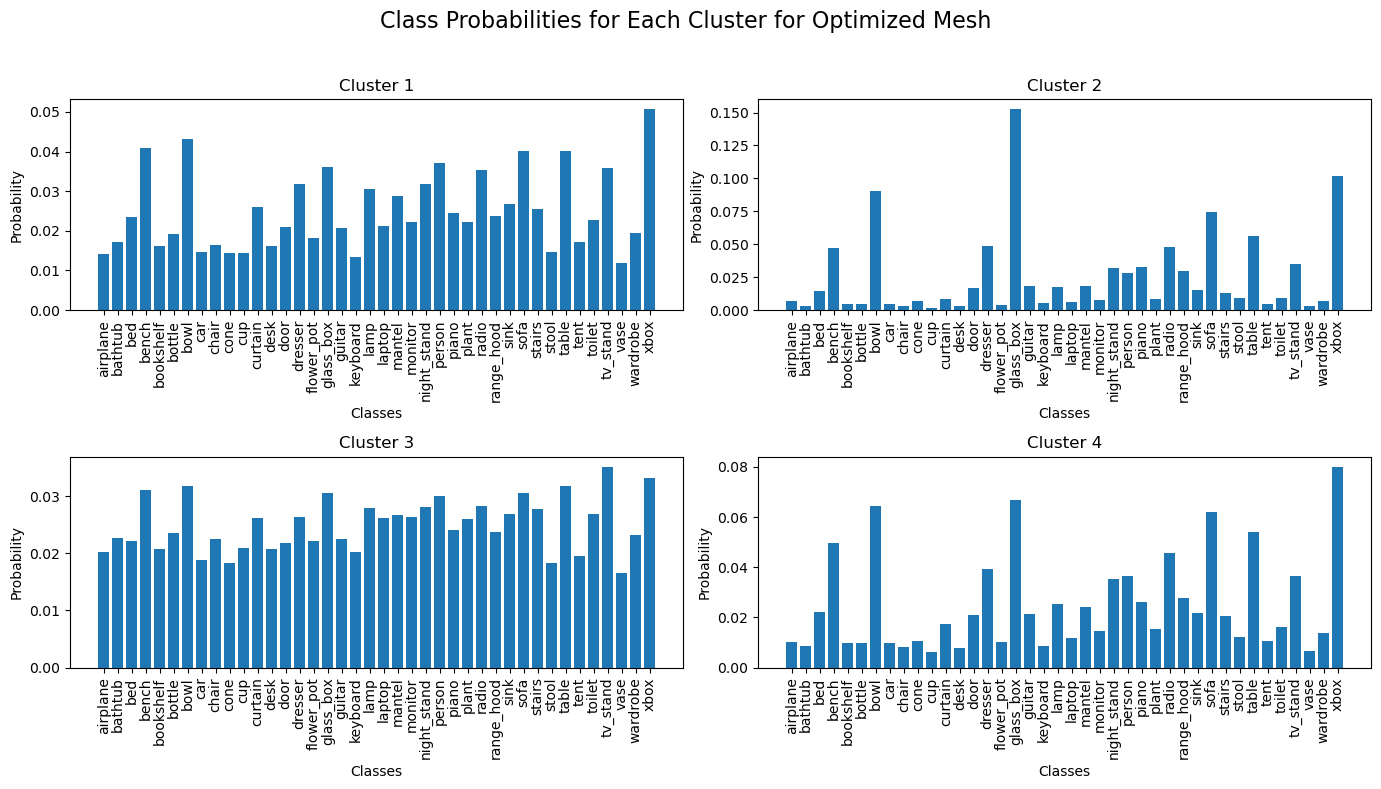

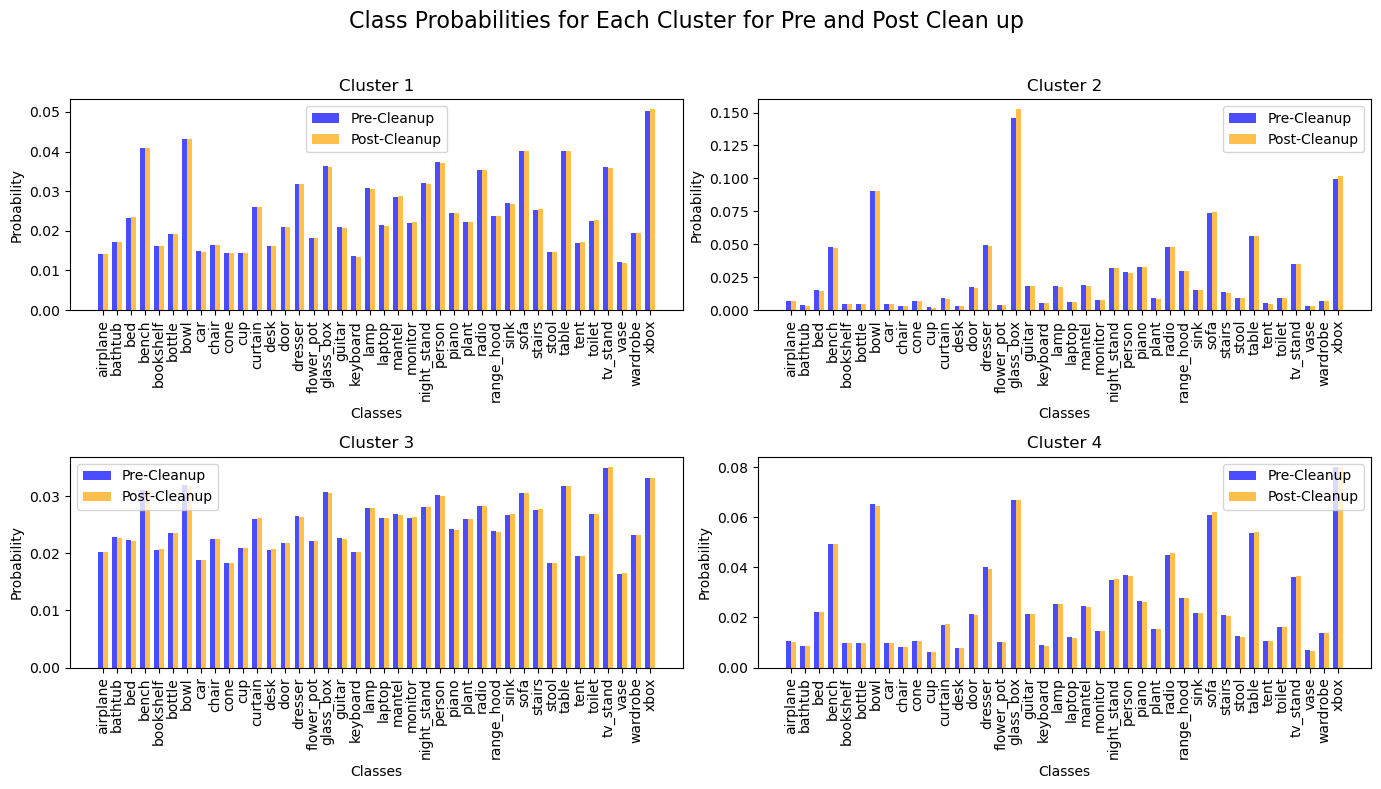

In [56]:
optimized_points = np.vstack(optimized_points)
optimized_clusters, _ = kmeans(optimized_points, num_clusters, init_centers)

all_probabilities = [] 

for optimized_cluster in optimized_clusters: 
    _, _, cluster_prob, _ = classify(optimized_cluster, model, class_names) 
    all_probabilities.append(cluster_prob) 

plot_class_histogram(probabilities_pre, class_names, "Pre-cleanup Mesh")
plot_class_histogram(all_probabilities, class_names, "Optimized Mesh")


plot_class_histogram_multiple(probabilities_pre, all_probabilities, class_names, "Pre and Post Clean up")

# Visualize the optimized point cloud
visualize(optimized_clusters)



In [ ]:
#### visualize(clusters_pre) 
pcd_pre.points = o3d.utility.Vector3dVector(points_pre)
#pcd_pre.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcd_pre.estimate_normals()
cleaned_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_pre)[0]
#point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30))
#point_cloud.orient_normals_consistent_tangent_plane(k=30)

#pcd_pre.orient_normals_consistent_tangent_plane(k=30)
#cleaned_mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_pre, depth=8, scale=1.1, linear_fit=True)

#cleaned_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud)[0]
cleaned_mesh.paint_uniform_color([0, 1, 0]) 
#cleaned_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=8)

# Step 1: Clean the mesh in memory (same as before)

cleaned_mesh.remove_duplicated_vertices()  # Removes duplicate vertices
cleaned_mesh.remove_duplicated_triangles() # Removes duplicate faces/triangles
cleaned_mesh.remove_non_manifold_edges()   # Fixes non-manifold edges
cleaned_mesh.remove_degenerate_triangles() # Removes degenerate (flat or zero-area) triangles

bbox = pcd_pre.get_axis_aligned_bounding_box()
cropped_mesh = cleaned_mesh.crop(bbox)


vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(cropped_mesh)

opt = vis.get_render_option()
opt.mesh_show_wireframe = True  # Enables wireframe
opt.mesh_show_back_face = True  # Ensures that back faces are visible

vis.run()
vis.destroy_window()